# SLM deployment

The **distil labs** platform allows anyone to benefit from state-of-the-art methods for model fine-tuning. You don’t need to be a machine learning expert to get a highly performant model customized to your needs in a matter of a day. 


## Objective
In this notebook we will deploy a trained question-answering small language model (SLM) with the **distil labs** platform. 

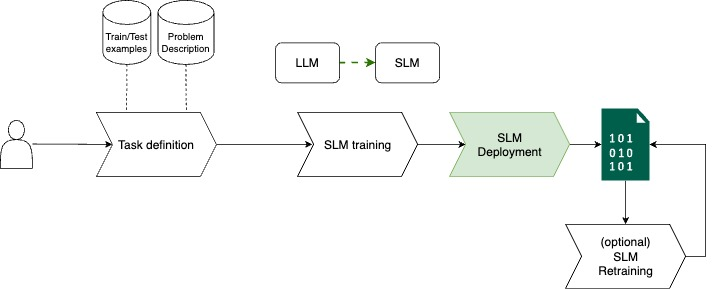


## Install dependencies
Please run the following cell to install the necessary dependencies in order to run this example. (Note that it is recommneded to use a virtual environment to install these dependencies.)

In [ ]:
! pip install torch transformers pandas

# Download Model
**NOTE: If you have already downloaded the model, you can skip this step**.


Once the model is fully trained, we can share the model binaries with you, so you can deploy it on your own infrastructure and have full control. The model binaries can be downloaded using the `model` API by downloading the tarball and extracting into to the `model` directory. 

The downloaded file will be called `*-model.tar`. Once extracted, you should find a `model/` directory which should be copied to the same directory as this notebook. At this point, your current working directory should look something like:

```
├── README.md
├── question-answering-model-deployment.ipynb
├── model
│   ├── config.json
│   ├── model.safetensors
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── training-logs.csv
│   └── training-logs.json
```


In [ ]:
import requests
import getpass
import json
import os

def distil_bearer_token(DL_USERNAME: str, DL_PASSWORD: str) -> str:
    response = requests.post(
        "https://cognito-idp.eu-central-1.amazonaws.com",
        headers={
            "X-Amz-Target": "AWSCognitoIdentityProviderService.InitiateAuth",
            "Content-Type": "application/x-amz-json-1.1",
        },
        data=json.dumps({
            "AuthParameters": {
                "USERNAME": DL_USERNAME,
                "PASSWORD": DL_PASSWORD,
            },
            "AuthFlow": "USER_PASSWORD_AUTH",
            "ClientId" : "4569nvlkn8dm0iedo54nbta6fd",
        })
    )
    response.raise_for_status()
    return response.json()["AuthenticationResult"]["AccessToken"]

DL_USERNAME = os.environ["DL_USERNAME"]
DL_PASSWORD = os.environ["DL_PASSWORD"]


AUTH_HEADER = {"Authorization": distil_bearer_token(DL_USERNAME, DL_PASSWORD)}
print("Success")

In [ ]:
from pprint import pprint

SLM_TRAINING_JOB_ID = "YOUR_MODEL_ID"

response = requests.get(
    f"https://api.distillabs.ai/trainings/model/{SLM_TRAINING_JOB_ID}",
    headers=AUTH_HEADER,
)
pprint(response.json())

# Model Deployment

We will use [huggingafce transformers](https://huggingface.co/docs/transformers/index) to host our model and use their standard API to make requests against it.

In [ ]:
import transformers

from transformers import AutoTokenizer, AutoModelForCausalLM


class HFModel:
    def __init__(self, model_directory: str = "model"):
        self.model = AutoModelForCausalLM.from_pretrained(model_directory)
        self.tokenizer = AutoTokenizer.from_pretrained(model_directory, padding_side="left")
        self.llm = transformers.pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
        )

    def get_prompt(self, question: str, context: str) -> str:
        message = [
            {
                "role": "system",
                "content": "You are a question-answering model working on a problem described in task_description XML block:\n<task_description>Answer the question using information in the context. Questions require information from more than one paragraph from the context to answer. </task_description>\nYou will be given a single task with context in context XML block and the question in question XML block\nAnswer the question and put your answer between the answer XML block.",
            },
            {
                "role": "user",
                "content": f"Now for the real task, answer the question in question block based on the context in context block.\n<context>\n{context}\n</context>\n<question>\n{question}\n</question>\nPlace the answer in answer XML block",
            },
        ]
        return self.tokenizer.apply_chat_template(
            message, tokenize=False, add_generation_prompt=True
        )

    def invoke(self, question: str, context: str) -> str:
        prompt = self.get_prompt(question=question, context=context)
        return self.llm(prompt, max_new_tokens=2048, return_full_text=False)

llm = HFModel("model")

In [ ]:
import pandas
from pathlib import Path

data_location = Path("data-hotpotqa")
test = pandas.read_csv(data_location.joinpath("test.csv"))

example = test.loc[0]
print(f"context:\n{example['context']}")
print(f"question:\n{example['question']}")

answer = llm.invoke(question=example['question'], context=example['context'])
print("\n\nAnswer:", answer)